# Module Dependencies

In [26]:
import pandas as pd 
import numpy as np
import os
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split

## Import Data

In [2]:
os.chdir(r"/Users/jonny/Python_work/DataScrum/Files/Final_files")
dataset = pd.read_csv("BOOH_cln.csv")

In [3]:
dataset.columns

Index(['dates', 'Open_OD', 'High_OD', 'Low_OD', 'Close_OD',
       'Adjusted_close_OD', 'Volume_OD', 'Open Price_REF', 'High Price_REF',
       'Low Price_REF', 'Close Price_REF', 'Accumulated Volume_REF',
       'Open_OD_adj', 'High_OD_adj', 'Low_OD_adj', 'Close_OD_adj',
       'Open Price_REF_adj', 'High Price_REF_adj', 'Low Price_REF_adj',
       'Close Price_REF_adj', 'desktop_page_views_sum',
       'desktop_visit_duration_weighted_mean',
       'desktop_bounce_rate_weighted_mean', 'mobile_page_views_sum',
       'mobile_visit_duration_weighted_mean',
       'mobile_bounce_rate_weighted_mean', 'composite_web_idx',
       'mobile_web_idx', 'current_installs', 'downloads', 'usage_time',
       'average_sessions_per_user', 'daily_active_users', 'usage_penetration',
       'open_rate', 'country_panel', 'company_panel',
       'Number of Included Estimates_DPS', 'Mean_DPS', 'High_DPS', 'Low_DPS',
       'Number of Included Estimates_EPS', 'Mean_EPS', 'High_EPS', 'Low_EPS',
       'Numb

In [4]:
dataset = dataset.set_index('dates')
dataset.index = pd.to_datetime(dataset.index,format='%Y-%m-%d')
dataset = dataset.sort_index()

In [5]:
traffic_columns = ['desktop_page_views_sum', 'desktop_visit_duration_weighted_mean',
                    'desktop_bounce_rate_weighted_mean', 'mobile_page_views_sum',
                    'mobile_visit_duration_weighted_mean',
                    'mobile_bounce_rate_weighted_mean', 'composite_web_idx',
                    'mobile_web_idx', 'current_installs', 'downloads', 'usage_time',
                    'average_sessions_per_user', 'daily_active_users', 'usage_penetration',
                    'open_rate', 'country_panel', 'company_panel']

#dataset[traffic] = dataset[analyst_est].fillna(method='ffill')

Create moving average for traffic data columns

In [6]:
ma_window = 7
dataset[[i+"_MA7" for i in traffic_columns]] = dataset[traffic_columns].rolling(window= ma_window).mean()

In [7]:
#impute analyst estimates using ffill
analyst_est =    ['Number of Included Estimates_DPS', 'Mean_DPS', 'High_DPS', 'Low_DPS',
                'Number of Included Estimates_EPS', 'Mean_EPS', 'High_EPS', 'Low_EPS',
                'Number of Included Estimates_NPR', 'Mean_NPR', 'High_NPR', 'Low_NPR',
                'Number of Included Estimates_PTP', 'Mean_PTP', 'High_PTP', 'Low_PTP',
                'Number of Included Estimates_REV', 'Mean_REV', 'High_REV', 'Low_REV']

dataset[analyst_est] = dataset[analyst_est].fillna(method='ffill')

In [8]:
#dataset = dataset.fillna(method='ffill')
dataset = dataset[(dataset.index.dayofweek <5).astype(float) == 1]
#check if we have na's between days
dataset = dataset[~((dataset['Close Price_REF_adj'].isna())|(dataset['Accumulated Volume_REF'].isna()))]

### Target variable


In [9]:
dataset['log returns'] = dataset['Close Price_REF_adj'].diff()

### Feature engineering

In [10]:
dataset['close-open'] = dataset['Close Price_REF_adj'] - dataset['Open Price_REF_adj']
dataset['high-low'] = dataset['High Price_REF_adj'] - dataset['Low Price_REF_adj']
dataset['vol_diff'] = dataset['Accumulated Volume_REF'].diff()
dataset['month'] = dataset.index.month
dataset['week'] = dataset.index.weekofyear
dataset['day'] = dataset.index.dayofyear


In [11]:
#Technica indictors
RSI_window = 14
delta = dataset['Close Price_REF_adj'].diff()
dUp,dDown = delta.copy(),delta.copy()
dUp[dUp<0] = 0
dDown[dDown>0] = 0
rUp = dUp.rolling(RSI_window).mean()
rDown = dDown.rolling(RSI_window).mean().abs()

RS= rUp/rDown
dataset['RSI_{}D'.format(RSI_window)] = RS

In [12]:
dataset.columns

Index(['Open_OD', 'High_OD', 'Low_OD', 'Close_OD', 'Adjusted_close_OD',
       'Volume_OD', 'Open Price_REF', 'High Price_REF', 'Low Price_REF',
       'Close Price_REF', 'Accumulated Volume_REF', 'Open_OD_adj',
       'High_OD_adj', 'Low_OD_adj', 'Close_OD_adj', 'Open Price_REF_adj',
       'High Price_REF_adj', 'Low Price_REF_adj', 'Close Price_REF_adj',
       'desktop_page_views_sum', 'desktop_visit_duration_weighted_mean',
       'desktop_bounce_rate_weighted_mean', 'mobile_page_views_sum',
       'mobile_visit_duration_weighted_mean',
       'mobile_bounce_rate_weighted_mean', 'composite_web_idx',
       'mobile_web_idx', 'current_installs', 'downloads', 'usage_time',
       'average_sessions_per_user', 'daily_active_users', 'usage_penetration',
       'open_rate', 'country_panel', 'company_panel',
       'Number of Included Estimates_DPS', 'Mean_DPS', 'High_DPS', 'Low_DPS',
       'Number of Included Estimates_EPS', 'Mean_EPS', 'High_EPS', 'Low_EPS',
       'Number of Included E

##### Clean-up

In [13]:
start_date = (~dataset.isna()).all(axis=1).idxmax()
end_date = (~dataset.isna()).all(axis=1)[::-1].idxmax()
dataset = dataset[(dataset.index>=start_date)&(dataset.index<=end_date)]
#filter for weekdays 

## Modelling Class

In [28]:
class company_model(object):
    
    def __init__(self,X,Y,model,w_size,w_type='expanding',lags=[1],settings=None):
        #Assume AR(1) default
        #set this to none if data is pre-lagged
        if lags:
            X = self.add_lags(X,lags)
            Y = Y[Y.index.isin(X.index)]
            
        self.X = X
        self.Y = Y
        self.model = model
        self.w_size = w_size
        self.w_type = w_type
                
        self.forecast_index = self.Y.index[self.w_size:]
        self.hyper_param,self.features,self.early_stopping = None,None,None
        
        if settings:
            self.hyper_param = settings.get('hyper_param',None)
            self.features = settings.get('features',None)
            self.early_stopping = settings.get('early_stopping',None)
            
            
            if self.hyper_param:
                self.cv_split = self.hyper_param.get('cv_split',TimeSeriesSplit(2))
                
            if self.early_stopping:
                self.test_size = round(self.w_size*(1-0.8))
            
        #output variables
        self.df_o_pred = pd.DataFrame(index=self.forecast_index)
        self.df_RMSE = pd.DataFrame()
        self.df_summary = pd.DataFrame()
        self.model_features = pd.DataFrame(index=self.forecast_index)
        self.best_hparam = pd.DataFrame(index=self.forecast_index)
    
    @staticmethod
    def add_lags(X,lags):
        df_X_lagged = pd.DataFrame()
        for l in lags:
            X_lagged = X.shift(l)
            X_lagged.columns = X.columns + "_T-{}".format(l)
            df_X_lagged = pd.concat([df_X_lagged,X_lagged],axis=1)
    
        return df_X_lagged.dropna()
    
    def hparameter_tuning(self,x,y):

        optimise = GridSearchCV(self.model,param_grid = self.hyper_param['params']
                                ,n_jobs = -1,
                                cv=self.cv_split,scoring='neg_mean_squared_error')\
                                .fit(x,y)
        
        best_params = optimise.best_params_
        best_model = self.model.set_params(**best_params)
        return best_model,best_params
    
    
    def predict(self,X_test):
        return self.model.predict(X_test)
        
    def fit_predict(self):
        best_hparam = None
        model_features = None

        for i,t in enumerate(self.forecast_index):
            
            j = 0 if self.w_type =='expanding' else i
            X_train,Y_train = X.iloc[j:self.w_size+i].values,Y.iloc[j:self.w_size+i].values
            X_test = X.iloc[w_size+i].values
            
            if self.hyper_param:
                self.model,best_param = self.hparameter_tuning(X_train,Y_train.ravel())
                best_hparam = [v for k,v in best_param.items()]
                
            if self.early_stopping:
                #split into train and validation
                X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size = self.test_size)
                self.model = self.model.fit(X_train,Y_train.ravel(),eval_set =[(X_val,Y_val)],**self.early_stopping)
            else:
                self.model = self.model.fit(X_train,Y_train.ravel())
 
            #self.model.fit(X_train,Y_train.ravel())
            insample_prediction = self.predict(X_train)
            outsample_prediction = self.predict(X_test.reshape(1,-1))[0]
            benchmark_prediction = np.mean(Y_train)
            
            insample_SSE = ((Y_train - insample_prediction)**2).sum(axis=0)
            insample_TSS = ((Y_train - benchmark_prediction)**2).sum(axis=0)
            insample_r2 = 1 - insample_SSE/insample_TSS
            
            if self.features:
                model_features = [getattr(self.model,f) for f in self.features]
            
            yield insample_r2,outsample_prediction,benchmark_prediction,best_hparam,model_features

    
    def produce_metrics(self):
        
        insample_r2,outsample_pred,benchmark_pred,best_hparam,model_features = list(zip(*self.fit_predict()))
        
        self.df_o_pred['model_predictions'] = outsample_pred
        self.df_o_pred['benchmark_predictions'] = benchmark_pred
        self.df_o_pred['actual'] = self.Y[self.Y.index.isin(self.df_o_pred.index)]        
        #sum of squared errors
        self.df_RMSE['model_SSE'] = self.Y.subtract(self.df_o_pred['model_predictions']).dropna()**2
        #cumulative RMSE
        self.df_RMSE['model_cum_RMSE'] = np.sqrt(self.df_RMSE['model_SSE'].expanding().mean())
        #sum of squared errors
        self.df_RMSE['benchmark_SSE'] = self.Y.subtract(self.df_o_pred['benchmark_predictions']).dropna()**2
        # cumulative RMSE
        self.df_RMSE['benchmark_cum_RMSE'] =  np.sqrt(self.df_RMSE['benchmark_SSE'].expanding().mean())
        
        res_dict = {}
        res_dict['model_RMSE'] = self.df_RMSE['model_cum_RMSE'].iloc[-1]
        res_dict['bench_RMSE'] = self.df_RMSE['benchmark_cum_RMSE'].iloc[-1]
        res_dict['model_r2oos'] = 1 - (self.df_RMSE['model_SSE'].sum(axis=0)/self.df_RMSE['benchmark_SSE'].sum(axis=0))
        res_dict['model_r2ins'] = np.mean(insample_r2)
        
        self.model_features['features'],self.best_hparam['parameters'] = list(model_features),list(best_hparam)
        
        return self.df_o_pred,self.df_RMSE,res_dict


In [15]:
def horizontal_plot(dplots,dplot_name):
    fig,axes = plt.subplots(nrows=1,ncols=len(dplots),figsize=(14,7))
    
    for i,p in enumerate(dplots):
        dates = pd.to_datetime(p.index)
        axes[i].plot(dates,p)
        axes[i].title.set_text(dplot_name[i])
        #axes[i].legend(loc="upper right")
    
    fig.autofmt_xdate(bottom=0.2, rotation=90, ha='right')
    fig.tight_layout()
    #fig.legend


## Dataset 1 - Prediction log returns

In [35]:
d1_cols = ['Close Price_REF_adj','Accumulated Volume_REF',
           'composite_web_idx_MA7','mobile_web_idx_MA7',
           #'usage_time_MA7', 'average_sessions_per_user_MA7',
           #'daily_active_users_MA7', 'usage_penetration_MA7', 'open_rate_MA7',
           'country_panel_MA7', 'company_panel_MA7',
           #'open_rate',
           'RSI_14D',
           'Number of Included Estimates_EPS','Mean_EPS',
           'high-low','vol_diff','day','month','week',


          ]

d1_cols = ['Close Price_REF_adj','Accumulated Volume_REF',
           'composite_web_idx_MA7','mobile_web_idx_MA7',
           #'usage_time_MA7', 'average_sessions_per_user_MA7',
           #'daily_active_users_MA7', 'usage_penetration_MA7', 'open_rate_MA7',
           'country_panel_MA7', 'company_panel_MA7',
           'open_rate',
           #'RSI_14D',
           'Number of Included Estimates_EPS','Mean_EPS',
           'high-low','vol_diff','day','month','week'


          ]

dataset_1 = dataset[d1_cols]


In [38]:
#settings 
w_size = 50
w_type ='rolling'
Y = dataset_1['Close Price_REF_adj']
#X = dataset[['Mean_EPS_diff','announcement day']]
X = dataset_1[[i for i in dataset_1.columns if i not in Y.name]]
#X = pd.DataFrame(normalize(X,axis=0),index=X.index,columns=X.columns)

#### Linear regression

In [39]:
model = LinearRegression(normalize=True)

linear_reg = company_model(X,Y,model,w_size,w_type,lags=[1])
predictions,RMSE_stats,summary = linear_reg.produce_metrics() 

print("\033[1mIn-sample R^2 is {}\033[1m".format(summary['model_r2ins']))
print("out-of-sample R^2 is {}".format(summary['model_r2oos']))

In-sample R^2 is 0.8767411010808464
out-of-sample R^2 is -125041366492458.06


In [43]:
predictions.to_clipboard()

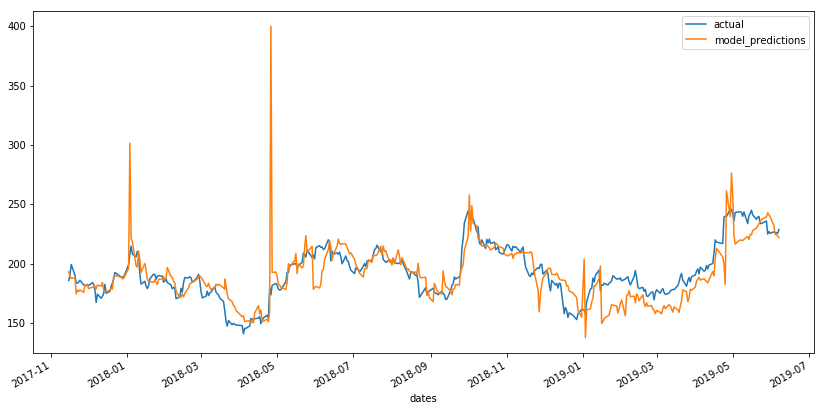

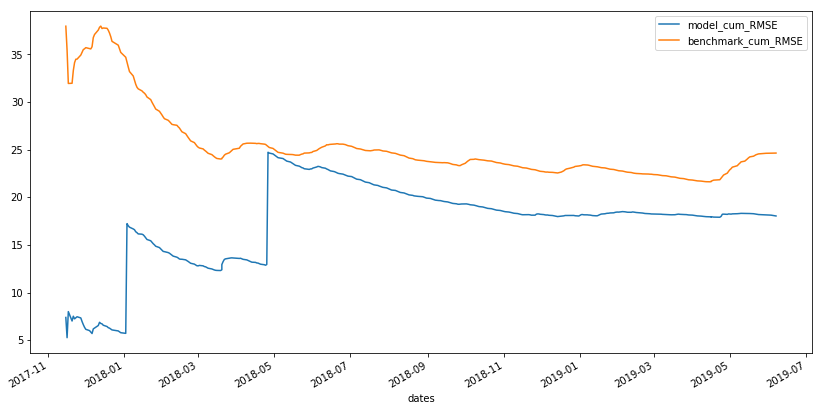

In [24]:
predictions[['actual','model_predictions']].plot(legend=True,figsize=(14,7))
RMSE_stats[['model_cum_RMSE','benchmark_cum_RMSE']].plot(legend=True,figsize=(14,7))

#### XGBoost

In [ ]:
settings = {"hyper_param":{"cv_split":TimeSeriesSplit(n_splits=2),
                           "params":{'min_samples_leaf':np.linspace(1,15,4),'max_depth':list(range(6,12))}}}

settings.update({"features":["feature_importances_"]})

settings.update({"early_stopping":{"early_stopping_rounds":10,"eval_metric":'rmse','verbose':False}})
model = xgb.XGBRegressor(learning_rate=0.05,n_estimators=300)
xgb_reg = company_model(X,Y,model,w_size,w_type,lags=[1],settings=settings)
predictions,RMSE_stats,summary = xgb_reg.produce_metrics() 

In [ ]:
print("\033[1mIn-sample R^2 is {}\033[1m".format(summary['model_r2ins']))
print("out-of-sample R^2 is {}".format(summary['model_r2oos']))

In [ ]:
predictions

In [ ]:
predictions[['actual','model_predictions']].plot(legend=True,figsize=(14,7))
RMSE_stats[['model_cum_RMSE','benchmark_cum_RMSE']].plot(legend=True,figsize=(14,7))


In [ ]:
unstacked_features = np.vstack(xgb_reg.model_features.apply(lambda x:list(x[0][0]),axis=1))
best_features = pd.DataFrame(unstacked_features,columns = xgb_reg.X.columns)

In [ ]:
best_features.rolling(10).mean().plot(legend=True,figsize=(14,7))

In [ ]:
best_features.mean(axis=0).sort_values(ascending=False)

In [ ]:
xgb_reg.best_hparam['parameters']

In [ ]:
best_features['mobile_web_idx_MA7_T-1'].plot(legend=True,figsize=(14,7))

#### Random Forest

In [ ]:
settings = {"features":["feature_importances_"]}
model = RandomForestRegressor(n_estimators=100)

rf_reg = company_model(X,Y,model,w_size,w_type,lags=[1],settings = settings) 
predictions,RMSE_stats,summary = rf_reg.produce_metrics() 

In [ ]:
print("\033[1mIn-sample R^2 is {}\033[1m".format(summary['model_r2ins']))
print("out-of-sample R^2 is {}".format(summary['model_r2oos']))

In [ ]:
predictions[['actual','model_predictions']].plot(legend=True,figsize=(14,7))
RMSE_stats[['model_cum_RMSE','benchmark_cum_RMSE']].plot(legend=True,figsize=(14,7))

In [ ]:
import itertools

abc = pd.DataFrame(rf_reg.model_features,columns = rf_reg.X.columns)
#pd.DataFrame.from_records(rf_reg.model_features.apply(lambda x:list(itertools.chain.from_iterable(x))))
#rf_reg.model_features.apply(lambda x:list(itertools.chain.from_iterable(x))).apply(pd.Series)

#pd.DataFrame([[tuple(itertools.chain.from_iterable(i)) for t,i in rf_reg.model_features.iterrows()]]).apply(pd.Series)

In [ ]:
abc = [tuple(itertools.chain.from_iterable(i)) for t,i in rf_reg.model_features.iterrows()]

In [ ]:
pd.DataFrame(abc)

## EDA

In [ ]:
dplots = [dataset['Close'],dataset['daily_returns'],dataset['Mean_REV_diff']]
dplot_name  = ["Close price","log returns","Mean_REV_diff"]
horizontal_plot(dplots = dplots,dplot_name=dplot_name)

## Q1. Does Mean_EPS_diff predict daily returns? 

In [ ]:
#find the biggest moves of every year
dataset['year'] = dataset.index.year
dataset.groupby('year')['Mean_EPS_diff'].idxmax()

In [ ]:
dataset.index[(dataset.index.day.isin([17,18,19])&(dataset.index.month.isin([7,10,12])))]

In [ ]:
dataset['announcement day'] = (dataset.index.day.isin([17,18,19])&(dataset.index.month.isin([7,10,12])))

In [ ]:
dataset['Mean_EPS_diff_adj'] = dataset['Mean_EPS_diff']*(~dataset['announcement day'])

In [ ]:
dataset['Mean_EPS_diff_adj'].idxmin()

In [ ]:
w_size = 50
w_type ='expanding'
model = LinearRegression(normalize=True)
Y = dataset['daily_returns']
#X = dataset[['Mean_EPS_diff','announcement day']]
X = dataset[['Mean_EPS_diff_adj']]
        
linear_reg = company_model(X,Y,model,w_size,w_type,lags=[1,2,3])
predictions,RMSE_stats,summary = linear_reg.produce_metrics() 

print("\033[1mIn-sample R^2 is {}\033[1m".format(summary['model_r2ins']))
print("out-of-sample R^2 is {}".format(summary['model_r2oos']))

In [ ]:
dplots = [predictions[['actual','model_predictions']],RMSE_stats[['model_cum_RMSE','benchmark_cum_RMSE']]]
dplot_name  = ["actual vs prediction","model vs mean RMSE"]
horizontal_plot(dplots = dplots,dplot_name=dplot_name)

## Q2. Does Web/App Traffic predict Mean_EPS? 

### Linear Regression

In [ ]:
w_size = 50
w_type ='expanding'
model = LinearRegression(normalize=True)
Y = dataset['Mean_EPS_diff_adj']
X = dataset[alt_columns]
        
linear_reg = company_model(X,Y,model,w_size,w_type,lags=[1])
predictions,RMSE_stats,summary = linear_reg.produce_metrics() 

print("\033[1mIn-sample R^2 is {}\033[1m".format(summary['model_r2ins']))
print("out-of-sample R^2 is {}".format(summary['model_r2oos']))

In [ ]:
dplots = [predictions[['actual','model_predictions']],RMSE_stats[['benchmark_cum_RMSE','model_cum_RMSE']]]
dplot_name  = ["linear actual vs prediction"," linear model vs mean RMSE"]
horizontal_plot(dplots = dplots,dplot_name=dplot_name)

### Lasso Regression 

In [ ]:
w_size = 50
w_type ='rolling'
model = Lasso(normalize=True)
Y = dataset['Mean_EPS_diff_adj']
X = dataset[alt_columns]
#np.linspace(0.0005,0.002,4)
cv_split = TimeSeriesSplit(n_splits=4)
settings = {"hyper_param":{"cv_split":cv_split,"params":{"alpha":np.linspace(0.0005,0.002,4)}}}
        
lasso_reg = company_model(X,Y,model,w_size,w_type,lags=[1],settings=settings)
predictions,RMSE_stats,summary = lasso_reg.produce_metrics()

In [ ]:
print("\033[1mIn-sample R^2 is {}\033[1m".format(summary['model_r2ins']))
print("out-of-sample R^2 is {}".format(summary['model_r2oos']))

In [ ]:
dplots = [predictions[['actual','model_predictions']],RMSE_stats[['benchmark_cum_RMSE','model_cum_RMSE']],lasso_reg.best_hparam['parameters'].apply(pd.Series)]
dplot_name  = ["lasso actual vs prediction","lasso model vs mean RMSE","Lasso hyper-parameters"]
horizontal_plot(dplots = dplots,dplot_name=dplot_name)

### Self-Selection Regression

In [ ]:
w_size = 50
w_type ='rolling'
model = LinearRegression(normalize=True)
Y = dataset['Mean_EPS']
X = dataset[['current_installs','downloads','usage_time','average_sessions_per_user','daily_active_users','usage_penetration','open_rate']]
        
linear_reg = company_model(X,Y,model,w_size,w_type,lags=[1])
predictions,RMSE_stats,summary = linear_reg.produce_metrics() 

print("\033[1mIn-sample R^2 is {}\033[1m".format(summary['model_r2ins']))
print("out-of-sample R^2 is {}".format(summary['model_r2oos']))

### Binary/Classification 

## Predicted EPS vs Estimated EPS

In [ ]:
lasso_EPS_model,lasso_EPS_est = lasso_reg.df_o_pred['model_predictions'],lasso_reg.df_o_pred['actual']
lasso_EPS_diff = lasso_EPS_est - lasso_EPS_model


In [ ]:
lasso_EPS_diff.plot()

In [ ]:
lasso_desc = lasso_EPS_diff.describe()
lasso_desc

In [ ]:
Z_scores = (lasso_desc - lasso_desc['mean'])/lasso_desc['std']

In [ ]:
Z_scores

In [ ]:
w_size = 50
w_type ='rolling'
model = LinearRegression(normalize=True)
Y = dataset['Mean_EPS']
X = dataset[['current_installs','downloads','usage_time','average_sessions_per_user','daily_active_users','usage_penetration','open_rate']]
        
linear_reg = company_model(X,Y,model,w_size,w_type,lags=[1])
predictions,RMSE_stats,summary = linear_reg.produce_metrics() 

# Does website traffic explain EPS?

In [ ]:
dataset[['total_visits','Mean_REV']].plot()

In [ ]:
web_cols = ['desktop_visits','desktop_pages_per_visit','desktop_visit_duration','desktop_bounce_rate','desktop_page_views']
app_cols = list(set(alt_columns).difference(web_cols))

In [ ]:
def horizontal_plot(dplots,dplot_name):
    fig,axes = plt.subplots(nrows=len(dplots),ncols=1,figsize=(15,12))
    
    for i,p in enumerate(dplots):
        dates = pd.to_datetime(p.index)
        axes[i].plot(dates,p)
        axes[i].title.set_text(dplot_name[i])
        #axes[i].legend(loc="upper right")
    
    fig.autofmt_xdate(bottom=0.2, rotation=90, ha='right')
    fig.tight_layout()
    fig.legend

In [ ]:
dplots = [dataset[['Mean_EPS',w]] for w in web_cols]
dplot_name = ["Mean_EPS vs {}".format(w) for w in web_cols]
    

In [ ]:
horizontal_plot(dplots,dplot_name)

In [ ]:
def horizontal_plot(dplots,dplot_name):
    fig,axes = plt.subplots(nrows=len(dplots),ncols=1,figsize=(15,15))
    
    for i,p in enumerate(dplots):
        dates = pd.to_datetime(p.index)
        axes2 = axes[i].twinx()
        axes[i].plot(dates,p.iloc[:,0],color='b')
        axes[i].set_ylabel(p.columns[0])
        axes[i].title.set_text(dplot_name[i])
        axes2.plot(dates,p.iloc[:,1],color = 'r')
        axes2.set_ylabel(p.columns[1])
        #axes[i].legend(loc="upper right")
    
    fig.autofmt_xdate(bottom=0.2, rotation=90, ha='right')
    fig.tight_layout()
    fig.legend

In [ ]:
dplots = [dataset[['Mean_REV',w]] for w in ['total_visits']]
dplot_name = ["Mean_EPS vs {}".format(w) for w in ['total_visits']]
horizontal_plot(dplots,dplot_name)

In [ ]:
fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(14,7))
dates = pd.to_datetime(dataset.index)
axes2 = axes[0].twinx()
axes[0].plot(dates,dataset['Mean_REV'],color = 'b')
axes[0].set_xlabel('time (s)')
axes[0].set_ylabel('exp')
axes2.plot(dates,dataset['total_visits'],color = 'r')
axes2.set_ylabel('views')
fig.autofmt_xdate(bottom=0.2, rotation=90, ha='right')
fig.tight_layout()
fig.legend



In [ ]:
def horizontal_plot(dplots,dplot_name):
    fig,axes = plt.subplots(nrows=1,ncols=len(dplots),figsize=(14,7))
    
    for i,p in enumerate(dplots):
        dates = pd.to_datetime(p.index)
        axes[i].plot(dates,p)
        axes[i].title.set_text(dplot_name[i])
        #axes[i].legend(loc="upper right")
    
    fig.autofmt_xdate(bottom=0.2, rotation=90, ha='right')
    fig.tight_layout()
    fig.legend